### MNIST - Deep Learning
where target varibale belongs from (0-9)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:

from tensorflow.examples.tutorials.mnist import input_data
mnist  = input_data.read_data_sets("MNIST_data/", one_hot=True)

'''MNIST data set taken with output labels as ONE-HOT-ENCODING, bcz the output of model is the probabilities for each
   data point in 10 class
   e.g.for "5" as input  y_original = [0  , 0  , 0  , 0   , 1   , 0   , 0  , 0,0,0]
                        y_predicted = [0.1, 0.2, 0.1, 0.03, 0.80, 0.04, 0.0, 0.01 ]'''

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


'MNIST data set taken with output labels as ONE-HOT-ENCODING, bcz the output of model is the probabilities for each\n   data point in 10 class\n   e.g.for "5" as input  y_original = [0  , 0  , 0  , 0   , 1   , 0   , 0  , 0,0,0]\n                        y_predicted = [0.1, 0.2, 0.1, 0.03, 0.80, 0.04, 0.0, 0.01 ]'

In [3]:
# Shape of train images cout and no of features

mnist.train.images.shape

(55000, 784)

In [4]:
# Shape of labels

mnist.train.labels.shape

(55000, 10)

Labels have 10 dimension as they are one hot incoded

In [5]:
# for checking CPU and GPU available to TF

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9185673513447277510
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3147261542
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14500564599349206567
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Model -1 Single Neuron Model (Input layer(786)-Softmax(output 10))

### Construction Phase of Model

In [6]:
# storing the mini-batch wise results in PLACE HOLDER

x       = tf.placeholder( tf.float32,  [None,784] ) # None used as length not none

# Weights hasn't been initialized using any initlizer
weights = tf.Variable(tf.zeros([784,10])) # 10 bcz taking 10 such softmax units as neurons

bias    = tf.Variable(tf.zeros([10])) # one bias for each neuron

In [7]:
# After summing appying the activation fn i.e. SOFTMAX here
# Predicted labels after applying activation fn

y_predicted = tf.nn.softmax(tf.matmul(x,weights) + bias)

In [8]:
# Actual labels corresponding the mini batch on input

y_actual = tf.placeholder(tf.float32, [None,10])

In [9]:
# Defining LOSS FUNCTION to be optimized later
# cross entropy or (average log loss) bcz (softmax used in case of multiclass classification)

#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual*tf.log(y_predicted) , reduction_indices=[1]))
# or 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_predicted , labels = y_actual))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
# Defining OPTIMIZER

optimizer = tf.train.GradientDescentOptimizer(0.05)  # learning rate = 0.05
training_op = optimizer.minimize(cross_entropy)  # updating 

In [14]:
# function for plotting DYNAMIC PLOTS - 
# funtion helps in updating the plot for each RPOCH and error

%matplotlib notebook
import time

def plt_dynamic(x, y, y_1, ax, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
    fig.canvas.draw()

### Execution Phase of Model

In [15]:
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()  # this initializes all the nodes declared above


<IPython.core.display.Javascript object>


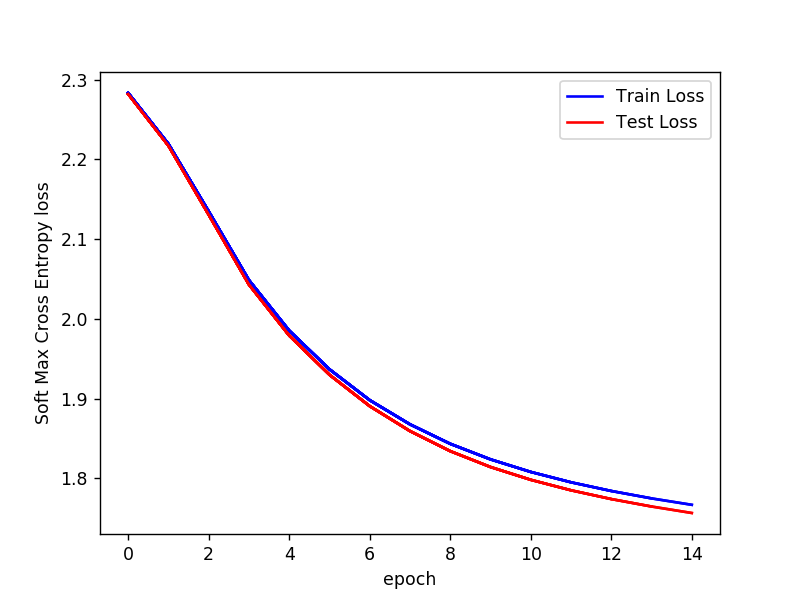

Accuracy: 0.8043


In [16]:
training_epoch = 15     # no of epochs = no of times whole trainig dataset have been fed
batch_size = 1000  # no of datapoints in each mini batch
display_step = 1

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
xs, ytrs, ytes = [], [], []

for epoch in range(training_epoch):
    
    total_batch = int(mnist.train.num_examples / batch_size) 
    train_avg_cost = 0
    test_avg_cost = 0
    
    for i in range(total_batch):
        
        batch_xs , batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([training_op, cross_entropy], feed_dict={x : batch_xs , y_actual : batch_ys})
        train_avg_cost += c / total_batch 
        
        c = sess.run(cross_entropy , feed_dict={x : mnist.test.images , y_actual : mnist.test.labels})
        test_avg_cost += c / total_batch
        
    xs.append(epoch)
    ytrs.append(train_avg_cost)
    ytes.append(test_avg_cost)
    plt_dynamic(xs, ytrs, ytes, ax)
        
        
plt_dynamic(xs, ytrs, ytes, ax)
correct_prediction = tf.equal(tf.argmax(y_predicted,1), tf.argmax(y_actual,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels}))

## Mutilayer Perceptron Model for MNIST

In [17]:
'''budling MLP with 2 hidden layers of 512 and 128 neurons each
    Input --> Hidden layer 1 --> Hidden layer 2 --> softmax --> output'''

n_input = 784      # dimesionality of dataset
n_hidden_1 = 512   # no of neurons in 1st hidden layer
n_hidden_2 = 128   # no of neurons in 2nd hidden layer
n_classes = 10       # output label (0-9)

In [18]:
x = tf.placeholder(tf.float32 , [None,784])
y_actual = tf.placeholder(tf.float32, [None,10])

# keep_prob placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)

# keep_prob placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [19]:
'''Weights Initialization--
    1. Xaviers Initialization -  used with SIGMOID activation
    2. He Initialization      -  used with ReLU activation    '''

# Initializing weights with XAVIERS NORMAL DISTRIBUTION - N(0,σ) 
# h1 =>  σ=√(2/(fan_in+fan_out+1),  ..... (1 included to save denominator from 0) , fan_it = 786 , fan_out = 512 
# h2 =>  σ=√(2/(fan_in+fan_out+1), fan_it = 512 , fan_out = 128
# out =>  σ=√(2/(fan_in+fan_out+1), fan_it = 128 , fan_out = 10
weights_sigmoid = {
    'h1' : tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),
    'h2' : tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))
}


# Initializing weights with HE NORMAL DISTRIBUTION - N(0,σ) 
# h1 =>  σ=√2√(2/(fan_in+fan_out+1), fan_it = 786 , fan_out = 512 
# h2 =>  σ=√2√(2/(fan_in+fan_out+1), fan_it = 512 , fan_out = 128
# out =>  σ=√2√(2/(fan_in+fan_out+1), fan_it = 128 , fan_out = 10
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}

# Initializing bases, bases = No of neurons per layer
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

<h2> Model 2: input (784) - sigmoid(512) - sigmoid(128) - 
softmax(output 10) </h2>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import time
def plot_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [21]:
def multilayer_perceprtron(x, weights, biases):
    
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())
    
    # Hidden layer 1 with sigmoid activation
    layer1 = tf.add(tf.matmul(x ,weights['h1'] ) , biases['b1'])
    layer1 = tf.nn.sigmoid(layer1)
    
    print( 'layer_1:', layer1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer 2 with sigmoid activation
    layer2 = tf.add(tf.matmul(layer1, weights['h2']) , biases['b2'])
    layer2 = tf.nn.sigmoid(layer2)
    
    print( 'layer_2:', layer2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())
    
    # Output layer with Sigmoid activation
    out_layer = tf.add( tf.matmul(layer2 , weights['out'] ) , biases['out'])
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer
    

### __ Model 2 + AdamOptimizer __

In [22]:
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


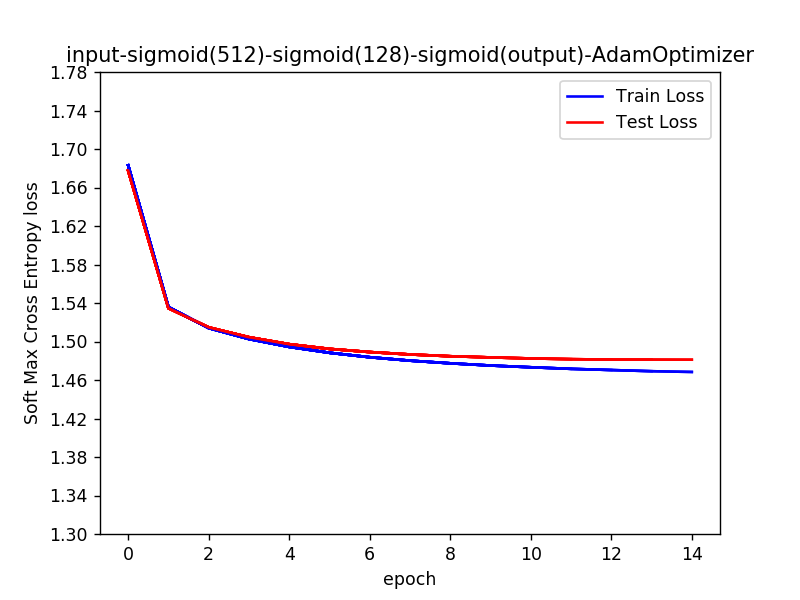

Epoch: 0001 train cost=1.682973194 test cost=1.677457247
Epoch: 0002 train cost=1.535827604 test cost=1.534623185
Epoch: 0003 train cost=1.513940124 test cost=1.514683656
Epoch: 0004 train cost=1.502577142 test cost=1.504463500
Epoch: 0005 train cost=1.494390344 test cost=1.497212439
Epoch: 0006 train cost=1.488273583 test cost=1.492327758
Epoch: 0007 train cost=1.483663021 test cost=1.489037232
Epoch: 0008 train cost=1.480095930 test cost=1.486538439
Epoch: 0009 train cost=1.477346440 test cost=1.484688282
Epoch: 0010 train cost=1.475032072 test cost=1.483477619
Epoch: 0011 train cost=1.473240657 test cost=1.482389272
Epoch: 0012 train cost=1.471583511 test cost=1.481658724
Epoch: 0013 train cost=1.470366488 test cost=1.481219376
Epoch: 0014 train cost=1.469143276 test cost=1.481211692
Epoch: 0015 train cost=1.468350208 test cost=1.481090505
Accuracy: 0.9794


In [23]:
# Using sigmoid activations in hiden layers, with XAVIERS weight iitialization
y_sigmoid = multilayer_perceprtron(x , weights_sigmoid, biases)
'''y_sigmoid is the output after passing from all the 3 layers and before the softmax activation'''

cross_entropy_sigmoid = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sigmoid, labels = y_actual))
'''cross_entropy_sigmoid is the loss function'''

# using ADAM OPTIMIZER
optimzer_adm = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimzer_adm.minimize(cross_entropy_sigmoid) # in this step weights get updated.

with tf.Session() as sess :
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # c: corresponds to the parameter cross_entropy_sigmoid
            # w : correspondse to the parameter weights_sigmoid
            # c = sess.run() return the cross entropy(log loss) after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
           
            # here we use AdamOptimizer
            _, c, w = sess.run([training_op, cross_entropy_sigmoid, weights_sigmoid], feed_dict={x: batch_xs, y_actual: batch_ys})
            train_avg_cost += c / total_batch
            
            c = sess.run(cross_entropy_sigmoid, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
            test_avg_cost += c / total_batch
            
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                     "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")
        
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                 "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")
    
    # calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sigmoid,1), tf.argmax(y_actual,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels}))
        
        


#### SANITY CHECK - To check wheter the weights are not too small nor too large


In [27]:
'''Checking weights have normal distribution or not, with small variance'''
print(w['h1'].shape)
print(w['h2'].shape)
print(w['out'].shape)

(784, 512)
(512, 128)
(128, 10)


<IPython.core.display.Javascript object>


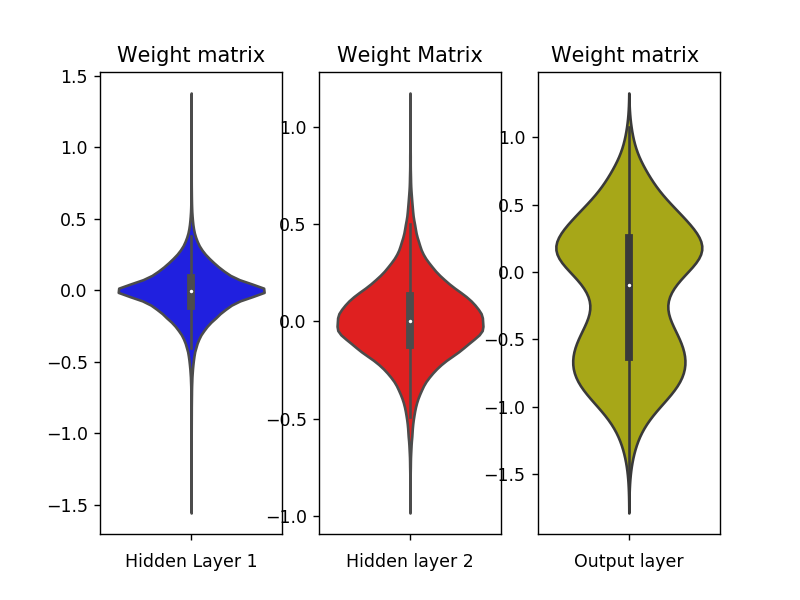

Text(0.5, 0, 'Output layer')

In [34]:
h1_w = w['h1'].flatten().reshape(-1,1) # flatten() to convert into 1D array
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight Matrix")
ax = sns.violinplot(y=h2_w,color='r')
plt.xlabel('Hidden layer 2')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w , color='y')
plt.xlabel("Output layer")

In [35]:
'''From plot it can be seen that weights have nearly NORMAL Distribution
   neither too small nor too large'''

'From plot it can be seen that weights have nearly NORMAL Distribution\n   neither too small nor too large'

### __ Model 2 + Mini Batch SGD __

<IPython.core.display.Javascript object>


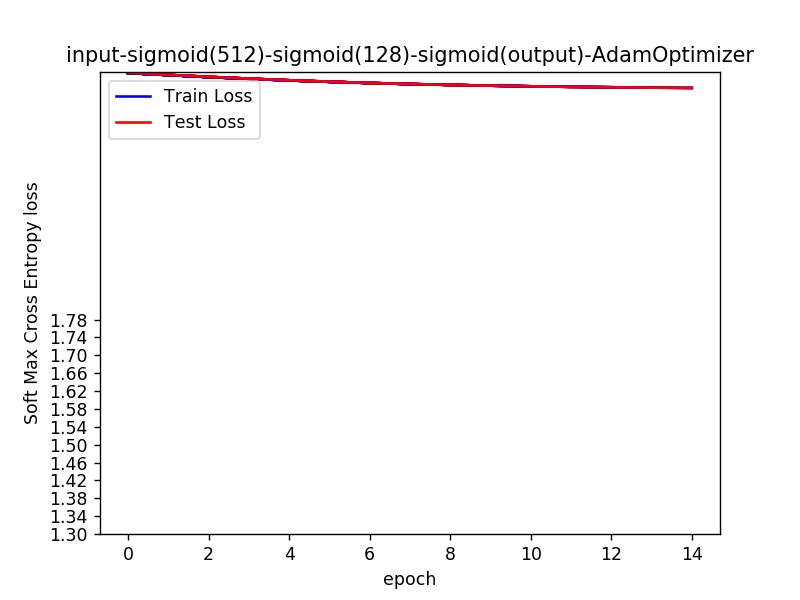

Epoch: 0001 train cost=2.331686808 test cost=2.332365688
Epoch: 0002 train cost=2.327225497 test cost=2.327592141
Epoch: 0003 train cost=2.322643151 test cost=2.323191996
Epoch: 0004 train cost=2.318849007 test cost=2.319194595
Epoch: 0005 train cost=2.315202951 test cost=2.315538657
Epoch: 0006 train cost=2.312096961 test cost=2.312328770
Epoch: 0007 train cost=2.309411127 test cost=2.309557463
Epoch: 0008 train cost=2.307024666 test cost=2.307186006
Epoch: 0009 train cost=2.305166020 test cost=2.305145411
Epoch: 0010 train cost=2.303430426 test cost=2.303466275
Epoch: 0011 train cost=2.302074937 test cost=2.302052000
Epoch: 0012 train cost=2.300889102 test cost=2.300864100
Epoch: 0013 train cost=2.299977642 test cost=2.299871685
Epoch: 0014 train cost=2.299158291 test cost=2.298986103
Epoch: 0015 train cost=2.298394845 test cost=2.298254942
Accuracy: 10.279999673366547


In [38]:
optimzer_SGD = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimzer_SGD.minimize(cross_entropy_sigmoid)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []

    for epoch in range(training_epochs):
        train_avg_cost = 0
        test_avg_cost = 0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            _, c, w = sess.run([training_op, cross_entropy_sigmoid, weights_sigmoid], feed_dict = {x:batch_xs, y_actual:batch_ys})
            train_avg_cost += c / total_batch
            
            c = sess.run(cross_entropy_sigmoid, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
            test_avg_cost += c / total_batch
            
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                     "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")
        
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                 "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")
    
    # calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sigmoid,1), tf.argmax(y_actual,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels})*100)    

<h3> Model 3 : input (784) - ReLu(512) - ReLu(128) - sigmoid(output 10) </h3>

In [39]:
def multilayer_perceprtron_relu(x, weights, biases):
    
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())
    
    # Hidden layer 1 with sigmoid activation
    layer1 = tf.add(tf.matmul(x ,weights['h1'] ) , biases['b1'])
    layer1 = tf.nn.relu(layer1)
    
    print( 'layer_1:', layer1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer 2 with sigmoid activation
    layer2 = tf.add(tf.matmul(layer1, weights['h2']) , biases['b2'])
    layer2 = tf.nn.relu(layer2)
    
    print( 'layer_2:', layer2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())
    
    # Output layer with Sigmoid activation
    out_layer = tf.add( tf.matmul(layer2 , weights['out'] ) , biases['out'])
    out_layer = tf.nn.relu(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer
    

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


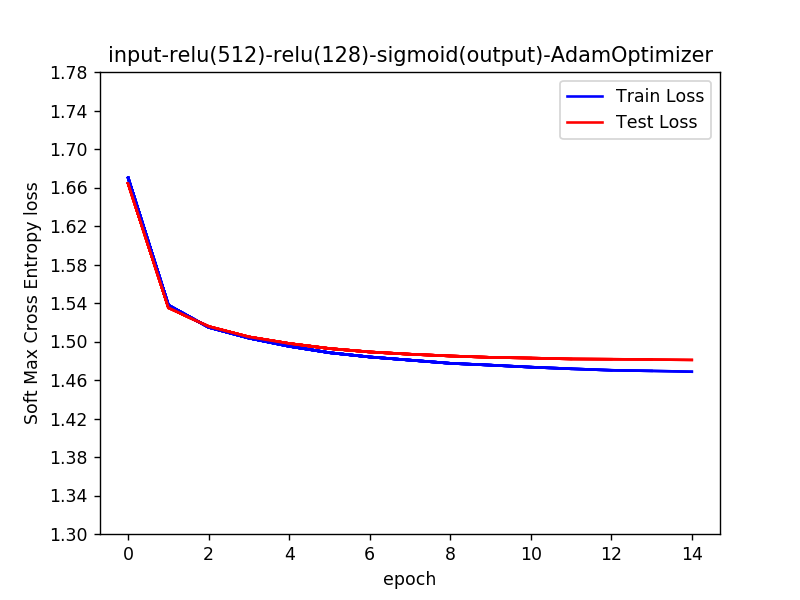

Epoch: 0001 train cost=1.669936791 test cost=1.664073297
Epoch: 0002 train cost=1.537700629 test cost=1.535188497
Epoch: 0003 train cost=1.514730107 test cost=1.515543525
Epoch: 0004 train cost=1.503534620 test cost=1.504737088
Epoch: 0005 train cost=1.494993378 test cost=1.497894330
Epoch: 0006 train cost=1.488364722 test cost=1.492685909
Epoch: 0007 train cost=1.483928548 test cost=1.489129949
Epoch: 0008 train cost=1.480638960 test cost=1.486780800
Epoch: 0009 train cost=1.477336529 test cost=1.484966383
Epoch: 0010 train cost=1.475446194 test cost=1.483524202
Epoch: 0011 train cost=1.473363385 test cost=1.482788172
Epoch: 0012 train cost=1.471657481 test cost=1.481867411
Epoch: 0013 train cost=1.470134384 test cost=1.481586000
Epoch: 0014 train cost=1.469464931 test cost=1.481315838
Epoch: 0015 train cost=1.468605398 test cost=1.480848318
Accuracy: 97.93000221252441


In [44]:
# Using sigmoid activations in hiden layers, with XAVIERS weight iitialization
y_relu = multilayer_perceprtron(x , weights_relu, biases)
'''y_sigmoid is the output after passing from all the 3 layers and before the softmax activation'''

cross_entropy_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_relu, labels = y_actual))
'''cross_entropy_sigmoid is the loss function'''

# using ADAM OPTIMIZER
optimzer_adm = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimzer_adm.minimize(cross_entropy_relu) # in this step weights get updated.

with tf.Session() as sess :
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                      
            # here we use AdamOptimizer
            _, c, w = sess.run([training_op, cross_entropy_relu, weights_relu], feed_dict={x: batch_xs, y_actual: batch_ys})
            train_avg_cost += c / total_batch
            
            c = sess.run(cross_entropy_relu, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
            test_avg_cost += c / total_batch
            
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                     "input-relu(512)-relu(128)-sigmoid(output)-AdamOptimizer")
        
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                 "input-relu(512)-relu(128)-sigmoid(output)-AdamOptimizer")

    # calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_relu,1), tf.argmax(y_actual,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels})*100)       


<IPython.core.display.Javascript object>


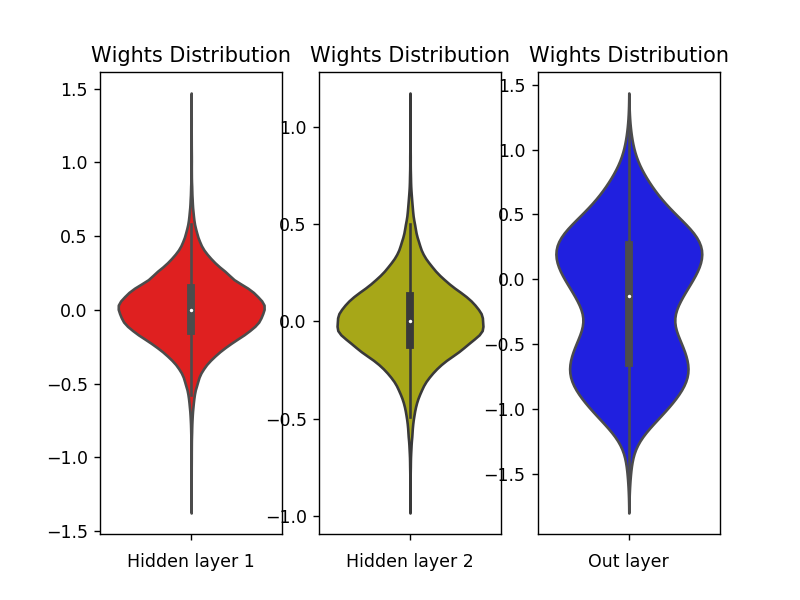

In [47]:
# Scanity checking of weights ---

h1_w =  w['h1'].flatten().reshape(-1,1)
h1_w =  w['h2'].flatten().reshape(-1,1)
out_w =  w['out'].flatten().reshape(-1,1)

fig = plt.figure()

plt.subplot(1,3,1)
sns.violinplot(y=h1_w , color='r')
plt.title("Wights Distribution")
plt.xlabel("Hidden layer 1")

plt.subplot(1,3,2)
sns.violinplot(y=h2_w , color='y')
plt.title("Wights Distribution")
plt.xlabel("Hidden layer 2")

plt.subplot(1,3,3)
sns.violinplot(y=out_w , color='b')
plt.title("Wights Distribution")
plt.xlabel("Out layer")

plt.show()

<h3> Model 4 : Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output) </h3>

In [48]:
epsilon = 1e-3

def multilayer_perceptron_batch(x, weights, biases):
    
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())
    
    layer_1 = tf.add( tf.matmul(x, weights['h1']), biases['b1'])
    
    # Applying BATCH NORMALIZATION before activation
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0]) # moments to find the mean and variance of tensor
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    layer_1 = tf.nn.batch_normalization(x = layer_1 , mean = batch_mean_1 , variance = batch_var_1 ,
                                       offset = beta_1 , scale= scale_1, variance_epsilon= epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape()) 
    
    ################################################################################
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) 
    
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer
    

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


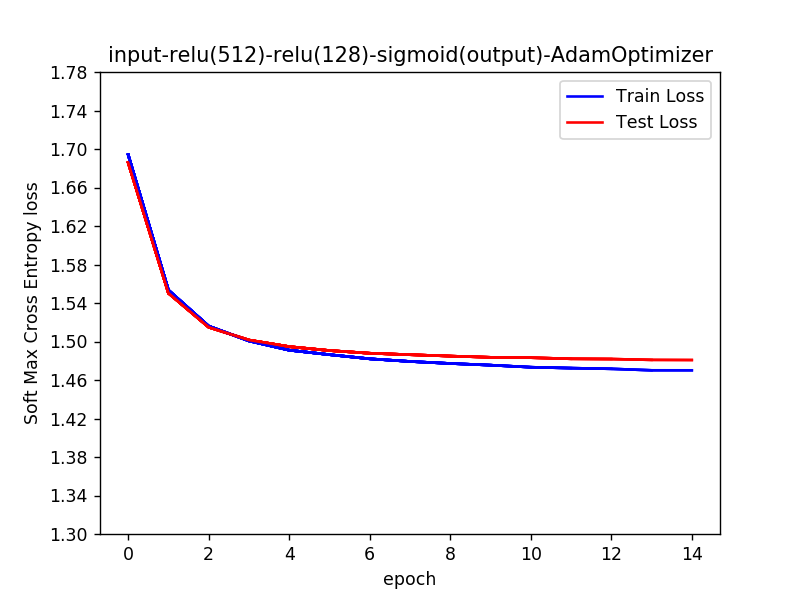

Epoch: 0001 train cost=1.694060706 test cost=1.685784415
Epoch: 0002 train cost=1.553356206 test cost=1.550227728
Epoch: 0003 train cost=1.515987690 test cost=1.514860088
Epoch: 0004 train cost=1.500603311 test cost=1.501497967
Epoch: 0005 train cost=1.490970488 test cost=1.494668043
Epoch: 0006 train cost=1.486324332 test cost=1.490602985
Epoch: 0007 train cost=1.482004015 test cost=1.487795004
Epoch: 0008 train cost=1.479261966 test cost=1.486281479
Epoch: 0009 train cost=1.477166868 test cost=1.484840764
Epoch: 0010 train cost=1.475425799 test cost=1.483580655
Epoch: 0011 train cost=1.473303374 test cost=1.483179234
Epoch: 0012 train cost=1.472358884 test cost=1.482025195
Epoch: 0013 train cost=1.471607025 test cost=1.481790357
Epoch: 0014 train cost=1.470092798 test cost=1.480904071
Epoch: 0015 train cost=1.470081091 test cost=1.480758922
Accuracy: 98.03000092506409


In [50]:
ybatch = multilayer_perceptron_batch(x, weights_sigmoid, biases)

cross_entropy_sigmoid = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_actual))

optimizer_batch_adm = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer_batch_adm.minimize(cross_entropy_sigmoid)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    
    for epoch in range(training_epoch):
        train_avg_cost = 0
        test_avg_cost = 0
        total_batch = int(mnist.train.num_examples/batch_size)
        
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            _, c, w = sess.run([training_op, cross_entropy_sigmoid, weights_sigmoid], feed_dict={x: batch_xs, y_actual: batch_ys})
            train_avg_cost += c / total_batch
            
            c = sess.run(cross_entropy_sigmoid, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels})
            test_avg_cost += c / total_batch
            
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                     "input-relu(512)-relu(128)-sigmoid(output)-AdamOptimizer")
        
        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    
    plot_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04),
                 "input-relu(512)-relu(128)-sigmoid(output)-AdamOptimizer")

    # calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_actual,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels})*100)       


In [51]:
# Using tehe Batch Initialization with Sigmoid Activation better ACCURACY can be achived

<h3> Model 5 : Input - ReLu(512) - Dropout - ReLu(128)- Dropout -Sigmoid(output) </h3>

In [53]:
def multilayer_perceptron_dropout(x, weights, biases):
    
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)


<IPython.core.display.Javascript object>


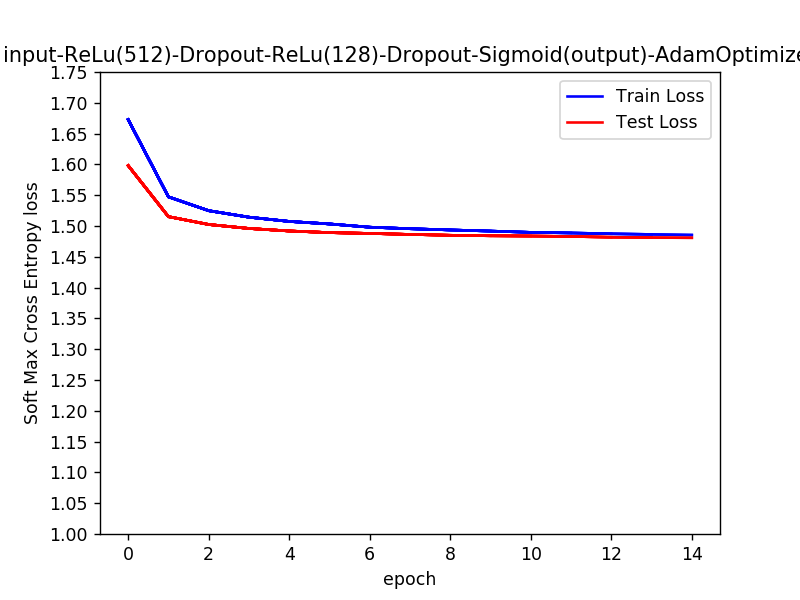

Epoch: 0001 train cost=1.672742091 test cost=1.598077139
Epoch: 0002 train cost=1.547326183 test cost=1.515173115
Epoch: 0003 train cost=1.524864656 test cost=1.502446710
Epoch: 0004 train cost=1.514304903 test cost=1.496001770
Epoch: 0005 train cost=1.507408357 test cost=1.491905433
Epoch: 0006 train cost=1.503343540 test cost=1.489269188
Epoch: 0007 train cost=1.498057260 test cost=1.487950868
Epoch: 0008 train cost=1.495585128 test cost=1.486317887
Epoch: 0009 train cost=1.493593562 test cost=1.484948640
Epoch: 0010 train cost=1.491760400 test cost=1.484122066
Epoch: 0011 train cost=1.489696609 test cost=1.483719395
Epoch: 0012 train cost=1.488705654 test cost=1.483040030
Epoch: 0013 train cost=1.487379251 test cost=1.481771288
Epoch: 0014 train cost=1.486363578 test cost=1.481201495
Epoch: 0015 train cost=1.485388544 test cost=1.480845498
Accuracy: 0.9743


In [57]:
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_actual))

optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)


with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_actual: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_actual: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plot_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plot_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_actual,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_actual: mnist.test.labels, keep_prob: 1.0 }))